In [1]:
import torch.nn as nn
import torch 
from typing import Iterable, List
import numpy as np

from torch.utils.data import Dataset, Sampler
from torch.utils.data.dataloader import _collate_fn_t, _worker_init_fn_t

from torchvision.transforms import PILToTensor

from typing import Any
import lightning as L
import torch.utils.data as tud
from torchvision.datasets import MNIST
import torch.optim as opt
import torch.nn.functional as F

import wandb


In [2]:

class Mlp(nn.Module):
    def __init__(self, dims, *args, **kwargs) -> None:
        super().__init__()

        self.linears = nn.ModuleList([
            nn.Linear(a, b) for a, b in zip(dims[:-1], dims[1:])
        ])

        self.act = nn.SELU()

    def forward(self, x):
        for layer in self.linears[:-1]:
            x = layer(x)
            x = self.act(x)

        final = self.linears[-1]
        return final(x)


class ResMlp(Mlp):
    def __init__(self, dims, *args, **kwargs) -> None:
        super().__init__(dims, *args, **kwargs)

    def forward(self, x):
        x = self.linears[0](x)
        x = self.act(x)
        for layer in self.linears[1:-1]:
            z = layer(x)
            x = self.act(z) + x

        final = self.linears[-1]
        return final(x)

In [3]:

from typing import Any

from torch.optim.optimizer import Optimizer


class Model(L.LightningModule):
    def __init__(self, n_layers, hidden_dim, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.mlp = ResMlp([28*28] + self.n_layers * [self.hidden_dim]+[10])

        self.save_hyperparameters()

        self.logging = {
            'grads_time': []
        }

    def training_step(self, batch, batch_index, *args: Any, **kwargs: Any):
        x, y = batch
        x = x.view(-1, 784)

        logits = self.mlp(x)
        labels = F.one_hot(y, num_classes=10).type(torch.float32)

        loss = nn.functional.cross_entropy(logits, labels)

        self.log('train_loss', loss)

        return loss

    def test_step(self, batch, *args):
        x, y = batch
        x = x.view(-1, 784)

        logits = self.mlp(x)

        top1_error = (torch.argmax(logits, -1) != y).sum()/y.shape[0]
        self.log('test/top1_error', top1_error)

        labels = F.one_hot(y, num_classes=10).type(torch.float32)

        loss = nn.functional.cross_entropy(logits, labels)

        self.log('test/cce_loss', loss)

        return loss

    # def

    # def
    def on_after_backward(self) -> None:
        # return super().on_after_backward()
        # are_grads = any(v.grad is not None for v in self.parameters())
        if not (self.global_step % 100):
            grad_clones = {k: v.grad.clone() for v, k in zip(
                self.parameters(), self.state_dict().keys())}
            self.logging['grads_time'].append((self.global_step, grad_clones))

    # def on_before_zero_grad(self, optimizer: Optimizer) -> None:

    #     are_grads = any(v.grad is not None for v in self.parameters())

    def on_train_start(self) -> None:
        # return super().on_train_start()
        self.init_params = {k: v.detach().clone() for k, v in self.state_dict(
        ).items() if 'weight' in k and v.shape[0] == v.shape[1]}

    def on_train_end(self) -> None:
        # return super().on_train_end()
        keys = list(self.init_params.keys())
        params = self.state_dict()
        diffs = [(k, params[k].detach() - self.init_params[k])
                 for k in keys]

        self.logging['diffs'] = diffs

    def configure_optimizers(self):

        optim = opt.AdamW(self.mlp.parameters())
        return optim

In [4]:
dummy_model = ResMlp([28*28, 1, 10])

X = torch.zeros((1, 28*28))
dummy_model(X)

tensor([[-0.1823, -0.4079, -0.9735,  0.0137,  0.4329,  0.2894, -0.3951, -0.7360,
          0.1737,  0.9719]], grad_fn=<AddmmBackward0>)

In [5]:


class MnistData(tud.Dataset):
    def __init__(self, train):
        self.mnist = MNIST('mnist', train=train)
        self.transform = PILToTensor()

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index):
        im, label = self.mnist[index]
        return  (self.transform(im)/255).type(torch.float32), label

In [6]:
model = Model(20, 5)
model.compile()

data = tud.DataLoader(MnistData(True), batch_size=256)
test_data = tud.DataLoader(MnistData(False), batch_size=1024)

logger = L.pytorch.loggers.WandbLogger()
# wandb.define_metric('layers', 'layer_k')

trainer = L.Trainer(max_epochs=2, logger=logger)
# trainer = L.Trainer(fast_dev_run=True, logger=logger)
# logger.watch(model)j

trainer.fit(model, data, test_data)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benkaye (ox-ben). Use `wandb login --relogin` to force relogin



  | Name | Type   | Params
--------------------------------
0 | mlp  | ResMlp | 4.6 K 
--------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 235/235 [00:07<00:00, 30.46it/s, v_num=2o6h]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 235/235 [00:07<00:00, 30.37it/s, v_num=2o6h]


In [7]:
trainer.test(model, test_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 31.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/cce_loss       │    0.8230375051498413     │
│      test/top1_error      │    0.24250000715255737    │
└───────────────────────────┴───────────────────────────┘

[{'test/top1_error': 0.24250000715255737, 'test/cce_loss': 0.8230375051498413}]

In [10]:
def analyse(model: Model):
    times, id_grads_at_t = zip(*model.logging['grads_time'])
    ids_grads_dct = {k: [pairs[k] for pairs in id_grads_at_t] for k in id_grads_at_t[0].keys()}
    flattened = {k: [a.flatten() for a in v] for k,v in ids_grads_dct.items()}

    keys = [f'mlp.linears.{k}.weight' for k in [4, 8, 12, 16]]


    k_ims = []
    for k in keys:
        tensor_list = flattened[k]
        im = torch.stack(tensor_list).cpu().numpy()
        k_ims.append((k, im))

    param_id, diffs = zip(*model.logging['diffs'])
    

    return k_ims
    
    

k_ims = analyse(model)


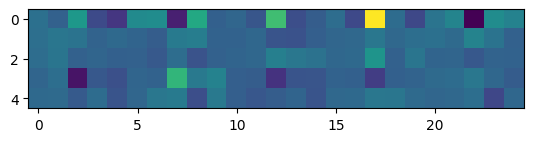

In [11]:
import matplotlib.pyplot as plt
def plot_waterfall(im):
    plt.imshow(im)

plot_waterfall(k_ims[-1][1])